# Gradient-based optimization

This notebook demonstrates single modified Adam optimizer.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [2]:
dr.__file__

'/home/yanni/mitsuba3/build/python/drjit/__init__.py'

In [3]:
scene = mi.load_file('scenes/cbox.xml', integrator='prb')

### Reference image

In [4]:
image_ref = mi.render(scene)
# print(image_ref.numpy())

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type  Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float PerspectiveCamera
  sensor.far_clip                               float PerspectiveCamera
  sensor.shutter_open                           float PerspectiveCamera
  sensor.shutter_open_time                      float PerspectiveCamera
  sensor.film.size                              ScalarVector2u HDRFilm
  sensor.film.crop_size                         ScalarVector2u HDRFilm
  sensor.film.crop_offset                       ScalarPoint2u HDRFilm
  sensor.x_fov                         ∂, D     Float PerspectiveCamera
  sensor.to_world                      ∂, D     Transform4f PerspectiveCamera
  gray.reflectance.value               ∂        Color3f SRGBReflectanceSpectrum
  white.re

### Initial state

In [6]:
key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])


# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
# params[key] = mi.Color3f(0,1,0)


params.update();

As expected, when rendering the scene again, the wall has changed color.

In [7]:
image_init = mi.render(scene)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## Optimization

There are three modified versions of Adam optimizer. The changes mainly happen in the square of the gradient we use to compute the second moment, and the weight across the iterations.
- AdamV: It uses the grad2 to substitute the square of gradient. The rest remains the same as the original Adam
- AdamC: It uses the counting number to form running exponentially weighted averages. The rest remains the same as the original Adam.
- AdamVC: It uses both the grad2 and the counting number. 
- AdamVCPrint: It is the same as the AdamVC, except that it returns several terms(e.g. weight of each iteration) that could be used for debugging and visualization.


In [8]:
# opt = mi.ad.Adam(lr=0.05)
# opt = mi.ad.AdamV(lr=0.05)
# opt = mi.ad.AdamC(lr=0.05)
opt = mi.ad.AdamVC(lr=0.05)
# opt = mi.ad.AdamVCPrint(lr=0.05)





opt[key] = params[key]

params.update(opt);

At every iteration of the gradient descent, we will compute the derivatives of the scene parameters with respect to the objective function. In this simple experiment, we use the [*mean square error*][1], or $L_2$ error, between the current image and the reference created above.

[1]: https://en.wikipedia.org/wiki/Mean_squared_error

In [9]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In the following cell we define the hyper parameters controlling our optimization loop, such as the number of iterations:

In [10]:
iteration_count = 50

In [11]:
# IGNORE THIS: When running under pytest, adjust parameters to reduce computation time
import os
if 'PYTEST_CURRENT_TEST' in os.environ:
    iteration_count = 2

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [12]:
errors = []
err_init = dr.sum(dr.sqr(param_ref - params[key]))
errors.append(err_init)
# wp1s =[]
# wp2s =[]
variances = []
grad2 = []
grad_counter = []

for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp =1)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss, flags = dr.ADFlag.BackPropVarianceCounter | dr.ADFlag.ClearVertices)


    # For variance visualization
    non_zero_mask = dr.neq(dr.counter(params[key]), 0)
    g2 = dr.grad2(params[key])
    gg_c = dr.select(non_zero_mask, dr.sqr(dr.grad(params[key]))/dr.counter(params[key]),0)
    variances.append(dr.sum(g2 - gg_c))
    grad2.append(dr.sum(g2))
    grad_counter.append(dr.sum(gg_c))

    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)
    
    # Track the difference between the current color and the true value
    err_ref = dr.sum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
    errors.append(err_ref)
print('\nOptimization complete.')

Iteration 49: parameter error = 0.000057
Optimization complete.


## Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

In [13]:
image_final = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_final)


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

It worked!

Note visualizing the objective value directly sometimes gives limited information, since differences between `image` and `image_ref` can be dominated by Monte Carlo noise that is not related to the parameter being optimized. 

Since we know the “true” target parameter in this scene, we can validate the convergence of the optimization by checking the difference to the true color at each iteration:

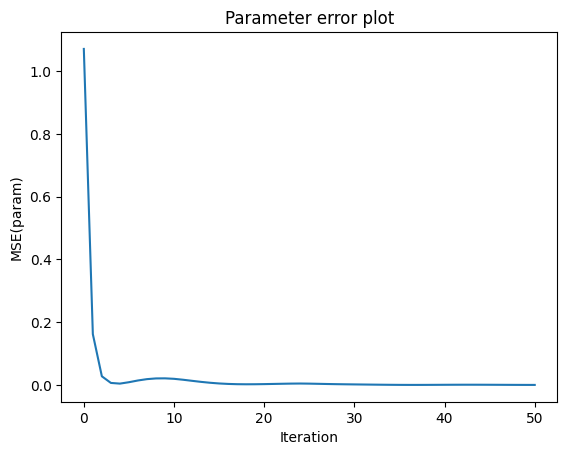

In [14]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()

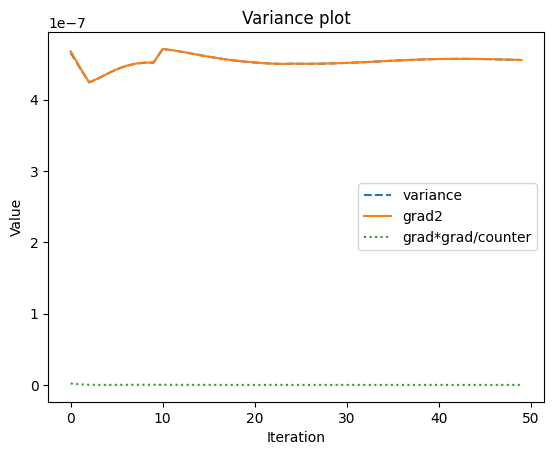

In [15]:
import matplotlib.pyplot as plt
# plt.plot(variances)

plt.plot(variances, linestyle='--',label='variance')
plt.plot(grad2, linestyle='-',label='grad2')
plt.plot(grad_counter, linestyle=':',label='grad*grad/counter')


plt.xlabel('Iteration'); plt.ylabel('Value'); plt.title('Variance plot');
plt.legend()
plt.show()

Check if the variances are all positive

In [16]:
import numpy as np
mask = np.array(variances) > 0
print(np.sum(mask))


50


If we use AdamVCPrint, we could plot the weight of each iteration

In [17]:
# plt.plot(wp1_r, color = 'r', linestyle='--',label='wp1_r')
# plt.plot(wp1_g, color = 'g', linestyle='-',label='wp1_g')
# plt.plot(wp1_b, color = 'b', linestyle=':',label='wp1_b')
# plt.legend()

# plt.xlabel('Iteration'); plt.ylabel('weight 1'); plt.title('Weight 1 for RGB channel from AdamVC');
# plt.show()


In [18]:
# import numpy as np
# a = np.array(wp2s)
# b = np.squeeze(a,axis=1)
# c = np.squeeze(b,axis=1)
# plt.plot(np.log(c[:,0]),  color = 'r', linestyle='--',label='wp2_r')
# plt.plot(np.log(c[:,1]),  color = 'g', linestyle='-',label='wp2_g')
# plt.plot(np.log(c[:,2]),  color = 'b', linestyle=':',label='wp2_b')
# plt.legend()

# plt.xlabel('Iteration'); plt.ylabel('weight 2'); plt.title('Weight 2 for RGB channel');
# plt.show()